# Μέρος 1. UCI dataset

Το dataset περιλαμβάνει data που συγκέντρωσε το MAGIC Telescope. Συγκεκριμένα, το τηλεσκόπιο τράβηξε δεκάδες χιλιάδες φωτογραφίες από electromagnetic showers στην ατμόσφαιρα. Αναλύοντας τις 10 παραμέτρους των shower images που προκύπτουν από το τηλεσκόπιο, κατηγοριοποιούμε τα showers σε εκείνα που προκλήθηκαν από gamma rays (g) και σε hadronic showers (h), δηλαδή σε εκείνα που προκλήθηκαν από τις κοσμικές ακτίνες της ατμόσφαιρας.
 Αναλυτικότερα στην [περιγραφή](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) από το UCI

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn import preprocessing
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

 Συνάρτηση που χρησιμοποιεί την cross_val_score function του scikit-learn για να κάνει cross-validation (εδώ 10-fold):

In [ ]:
def evaluate_classifier(clf, X, y, folds=10):
	scores = cross_val_score(clf, X, y, cv=folds)
	return np.mean(scores)

**Εισαγωγή και επισκόπηση:**

In [ ]:
#Dataloading
df = pd.read_csv("magic04.data", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


Δεν κάναμε κάποια μετατροπή στο dataset πρωτού το ανεβάσαμε. Επίσης διαβάσαμε στην περιγραφή ότι δεν περιλαμβάνει κενές τιμές.

Eπαλήθευση:

In [ ]:
df.isnull().values.any()

False

Παρατηρούμε ότι δεν περιλαμβάνει επικεφαλίδες εκτυπώνοντας την 1η σειρά:

In [ ]:
print(df.values[0])

[28.7967 16.0021 2.6449 0.3918 0.1982 27.7004 22.011 -8.2027 40.092
 81.8828 'g']


χωρίζουμε τα data : features (x) , labels (y)

In [ ]:
featueres_df=df.loc[:,0:9]
labels_df=df.loc[:,10:10]
print(featueres_df.shape)
print(labels_df.shape)

(19020, 10)
(19020, 1)


παρουσιάζονται καλύτερα ως numpy arrays:


*  features: nympy array of 19020 rows and 10 columns
*  19020 δείγματα με 10 χαρακτηριστικά το κάθε ένα

In [ ]:
features=featueres_df.values
print(features)
print(features.shape)

[[ 28.7967  16.0021   2.6449 ...  -8.2027  40.092   81.8828]
 [ 31.6036  11.7235   2.5185 ...  -9.9574   6.3609 205.261 ]
 [162.052  136.031    4.0612 ... -45.216   76.96   256.788 ]
 ...
 [ 75.4455  47.5305   3.4483 ...  -9.4662  30.2987 256.5166]
 [120.5135  76.9018   3.9939 ... -63.8389  84.6874 408.3166]
 [187.1814  53.0014   3.2093 ...  31.4755  52.731  272.3174]]
(19020, 10)


Labels: numpy array of 19020 rows and 1 column


In [ ]:
labels=labels_df.values.reshape(19020,)
print(labels)
print(labels.shape)

['g' 'g' 'g' ... 'h' 'h' 'h']
(19020,)


Ο τύπος των δεδομένων στα features είναι float:

In [ ]:
print(type(features[0,0]))

<class 'numpy.float64'>


Ο τύπος των δεδομένων στα labels είναι string:

In [ ]:
print(type(labels[0]))

<class 'str'>


Επομένως:
* Oι κλάσεις βρίσκονται στην τελευταία στήλη και διακρίνονται σε "gamma" : "g" και "hadron" : "h".
* Δεν έχουμε επικεφαλίδες ούτε αρίθμηση γραμμών
* Δεν απουσιάζει κανένα δείγμα






Έλεγχος αν το dataset είναι balanced:

In [ ]:
print("number of classes: 2")
print("number of samples of both classes: ",len(labels))
g=np.sum(df.values[:, -1] == 'g')
h=np.sum(df.values[:, -1] == 'h')
print("number of g: ",g,", number of h: ",h)
perc=min(g,h)/len(labels)
if perc<0.4:
  print("Not balanced. Min class percentage = ",perc," (should be atleast 40%)")
else:
  print("Balanced. Min class percentage = ",perc)


number of classes: 2
number of samples of both classes:  19020
number of g:  12332 , number of h:  6688
Not balanced. Min class percentage =  0.3516298633017876  (should be atleast 40%)


Διαχωρίζουμε το σύνολο δεδομένων σε σύνολο εκπαίδευσης (train set) και σύνολο (test set) με 30% των δειγμάτων στο test set

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =train_test_split(features,labels,test_size=0.3)

In [ ]:
label_names=['gamma','hadron']

# Dummy Classifier:

In [ ]:
from sklearn.dummy import DummyClassifier
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_g = DummyClassifier(strategy="constant", constant='g')
dc_constant_h = DummyClassifier(strategy="constant", constant='h')
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

In [ ]:
magic_accuracy = {}
dc_uniform.fit(x_train, y_train)
magic_accuracy['uniform (random)'] = dc_uniform.score(x_train, y_train)
model = dc_constant_g.fit(x_train, y_train)
magic_accuracy['constant g'] = dc_constant_g.score(x_train, y_train)
model = dc_constant_h.fit(x_train, y_train)
magic_accuracy['constant h'] = dc_constant_h.score(x_train, y_train)
model = dc_most_frequent.fit(x_train, y_train)
magic_accuracy['most frequent label'] = dc_most_frequent.score(x_train, y_train)
model = dc_stratified.fit(x_train, y_train)
magic_accuracy['stratified'] = dc_stratified.score(x_train, y_train)


In [ ]:
print("Classification Accuracy on the magic Dataset (30% test set)\n")
sorted_accuracy = [(k, magic_accuracy[k]) for k in sorted(magic_accuracy, key=magic_accuracy.get, reverse=True)]
for k, v in sorted_accuracy:
  print(k,v)

Classification Accuracy on the magic Dataset (30% test set)

constant g 0.6465374793450503
most frequent label 0.6465374793450503
stratified 0.546116869460718
uniform (random) 0.5085624155024786
constant h 0.35346252065494965


In [ ]:
x=features
y=labels

Dummy Classifier Baseline:
Classification Test Accuracy: 55.853%
Classification Validation Accuracy: 54.942%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


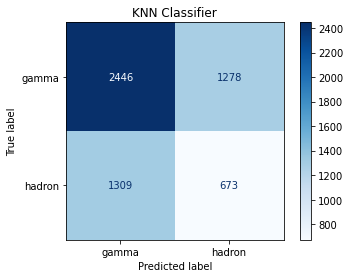

              precision    recall  f1-score   support

       gamma       0.65      0.65      0.65      3724
      hadron       0.34      0.35      0.34      1982

    accuracy                           0.54      5706
   macro avg       0.50      0.50      0.50      5706
weighted avg       0.54      0.54      0.54      5706

F1_Micro Score: 54.101%
F1_Macro Score: 49.519%

KNN Classifier Baseline:
Classification Test Accuracy: 80.529%
Classification Validation Accuracy: 80.836%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


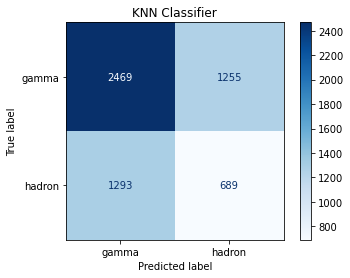

              precision    recall  f1-score   support

       gamma       0.81      0.91      0.86      3724
      hadron       0.79      0.60      0.68      1982

    accuracy                           0.81      5706
   macro avg       0.80      0.76      0.77      5706
weighted avg       0.80      0.81      0.80      5706

F1_Micro Score: 80.529%
F1_Macro Score: 77.067%

Naive Bayes Classifier Baseline:
Classification Test Accuracy: 72.643%
Classification Validation Accuracy: 72.687%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


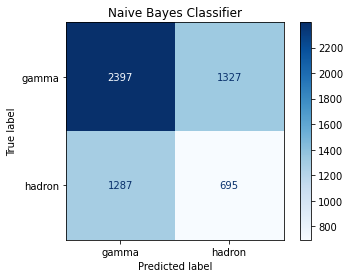

              precision    recall  f1-score   support

       gamma       0.74      0.91      0.81      3724
      hadron       0.69      0.39      0.49      1982

    accuracy                           0.73      5706
   macro avg       0.71      0.65      0.65      5706
weighted avg       0.72      0.73      0.70      5706

F1_Micro Score: 72.643%
F1_Macro Score: 65.355%

SVM Classifier Baseline:
Classification Test Accuracy: 82.790%
Classification Validation Accuracy: 82.450%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


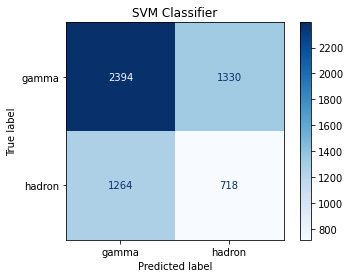

              precision    recall  f1-score   support

       gamma       0.81      0.96      0.88      3724
      hadron       0.88      0.59      0.70      1982

    accuracy                           0.83      5706
   macro avg       0.85      0.77      0.79      5706
weighted avg       0.84      0.83      0.82      5706

F1_Micro Score: 82.790%
F1_Macro Score: 79.076%

MLP Classifier Baseline:
Classification Test Accuracy: 83.596%


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classification Validation Accuracy: 84.343%


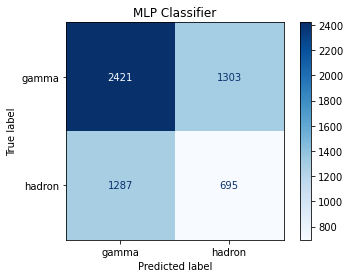

              precision    recall  f1-score   support

       gamma       0.85      0.91      0.88      3724
      hadron       0.80      0.70      0.75      1982

    accuracy                           0.84      5706
   macro avg       0.83      0.80      0.81      5706
weighted avg       0.83      0.84      0.83      5706

F1_Micro Score: 83.596%
F1_Macro Score: 81.309%



In [ ]:
#Dmmy classification

#Dummy CLassifier
print("Dummy Classifier Baseline:")
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='stratified')
dc.fit(x_train, y_train)
score = dc.score(x_test, y_test)
print('Classification Test Accuracy: {:.3f}%'.format(100 * score))
score = evaluate_classifier(dc, x, y, folds=10)
print('Classification Validation Accuracy: {:.3f}%'.format(100 * score))
pred = dc.predict(x_test)
disp = plot_confusion_matrix(dc, x_test, y_test,
                              display_labels=label_names,
                              cmap=plt.cm.Blues,
                              normalize=None, values_format='d')
disp.ax_.set_title('KNN Classifier')
plt.show()
print(classification_report(y_test, pred, target_names=label_names))
dc_f1_m = f1_score(y_test,pred,average='micro')
dc_f1_M = f1_score(y_test,pred,average='macro')
print('F1_Micro Score: {:.3f}%'.format(100 * dc_f1_m))
print('F1_Macro Score: {:.3f}%'.format(100 * dc_f1_M))
print("")

#KNN CLassifier
print("KNN Classifier Baseline:")
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)
print('Classification Test Accuracy: {:.3f}%'.format(100 * score))
score = evaluate_classifier(knn, x, y, folds=10)
print('Classification Validation Accuracy: {:.3f}%'.format(100 * score))
pred = knn.predict(x_test)
disp = plot_confusion_matrix(dc, x_test, y_test,
                              display_labels=label_names,
                              cmap=plt.cm.Blues,
                              normalize=None, values_format='d')
disp.ax_.set_title('KNN Classifier')
plt.show()
print(classification_report(y_test, pred, target_names=label_names))
knn_f1_m = f1_score(y_test,pred,average='micro')
knn_f1_M = f1_score(y_test,pred,average='macro')
print('F1_Micro Score: {:.3f}%'.format(100 * knn_f1_m))
print('F1_Macro Score: {:.3f}%'.format(100 * knn_f1_M))
print("")

#Naive Bayes CLassifier
print("Naive Bayes Classifier Baseline:")
gauss = GaussianNB()
gauss.fit(x_train, y_train)
score = gauss.score(x_test, y_test)
print('Classification Test Accuracy: {:.3f}%'.format(100 * score))
score = evaluate_classifier(gauss, x, y, folds=10)
print('Classification Validation Accuracy: {:.3f}%'.format(100 * score))
pred = gauss.predict(x_test)
disp = plot_confusion_matrix(dc, x_test, y_test,
                              display_labels=label_names,
                              cmap=plt.cm.Blues,
                              normalize=None, values_format='d')
disp.ax_.set_title('Naive Bayes Classifier')
plt.show()
print(classification_report(y_test, pred, target_names=label_names))
gauss_f1_m = f1_score(y_test,pred,average='micro')
gauss_f1_M = f1_score(y_test,pred,average='macro')
print('F1_Micro Score: {:.3f}%'.format(100 * gauss_f1_m))
print('F1_Macro Score: {:.3f}%'.format(100 * gauss_f1_M))
print("")

#SVM CLassifier
print("SVM Classifier Baseline:")
sv = svm.SVC()
sv.fit(x_train, y_train)
score = sv.score(x_test, y_test)
print('Classification Test Accuracy: {:.3f}%'.format(100 * score))
score = evaluate_classifier(sv, x, y, folds=10)
print('Classification Validation Accuracy: {:.3f}%'.format(100 * score))
pred = sv.predict(x_test)
disp = plot_confusion_matrix(dc, x_test, y_test,
                              display_labels=label_names,
                              cmap=plt.cm.Blues,
                              normalize=None, values_format='d')
disp.ax_.set_title('SVM Classifier')
plt.show()
print(classification_report(y_test, pred, target_names=label_names))
svm_f1_m = f1_score(y_test,pred,average='micro')
svm_f1_M = f1_score(y_test,pred,average='macro')
print('F1_Micro Score: {:.3f}%'.format(100 * svm_f1_m))
print('F1_Macro Score: {:.3f}%'.format(100 * svm_f1_M))
print("")

#MLP CLassifier
print("MLP Classifier Baseline:")
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
score = mlp.score(x_test, y_test)
print('Classification Test Accuracy: {:.3f}%'.format(100 * score))
score = evaluate_classifier(mlp, x, y, folds=10)
print('Classification Validation Accuracy: {:.3f}%'.format(100 * score))
pred = mlp.predict(x_test)
disp = plot_confusion_matrix(dc, x_test, y_test,
                              display_labels=label_names,
                              cmap=plt.cm.Blues,
                              normalize=None, values_format='d')
disp.ax_.set_title('MLP Classifier')
plt.show()
print(classification_report(y_test, pred, target_names=label_names))
mlp_f1_m = f1_score(y_test,pred,average='micro')
mlp_f1_M = f1_score(y_test,pred,average='macro')
print('F1_Micro Score: {:.3f}%'.format(100 * mlp_f1_m))
print('F1_Macro Score: {:.3f}%'.format(100 * mlp_f1_M))
print("")

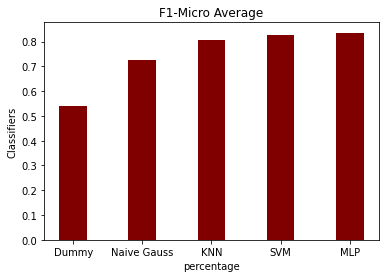

[0.54100946 0.72642832 0.80529267 0.82790046 0.83596215]


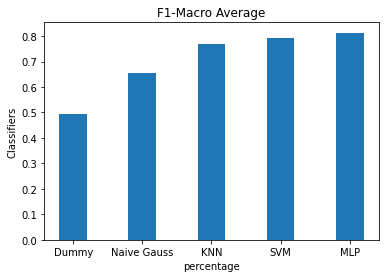

[0.49519393 0.65355295 0.77067299 0.7907597  0.81309101]


In [ ]:
labels = ['Dummy','Naive Gauss','KNN','SVM','MLP']
values = np.array([dc_f1_m,gauss_f1_m,knn_f1_m,svm_f1_m,mlp_f1_m])

  
# creating the bar plot 
plt.bar(labels, values, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("percentage") 
plt.ylabel("Classifiers") 
plt.title("F1-Micro Average") 
plt.show() 
print(values)



values = np.array([dc_f1_M,gauss_f1_M,knn_f1_M,svm_f1_M,mlp_f1_M])

  
# creating the bar plot 
plt.bar(labels, values,  
        width = 0.4) 
  
plt.xlabel("percentage") 
plt.ylabel("Classifiers") 
plt.title("F1-Macro Average") 
plt.show()
print(values)



# Βελτιστοποίηση

Dummy optimization - f1_micro
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py", line 144, in fit
    % (self.strategy, allowed_strategies)
ValueError: Unknown strategy type: statified


Optimal parameters tuned on dev set: {'gnb__strategy': 'most_frequent', 'sampler__sampling_strategy': 0.55}

Χρόνος fit=8.802713394165039, Χρόνος predict=0.002475261688232422, Συνολικός χρόνος=8.805188655853271  seconds



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


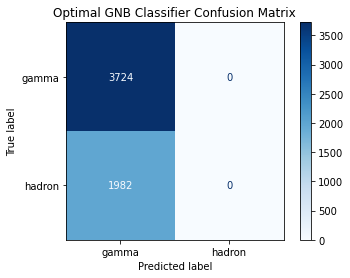

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       gamma       0.65      1.00      0.79      3724
      hadron       0.00      0.00      0.00      1982

    accuracy                           0.65      5706
   macro avg       0.33      0.50      0.39      5706
weighted avg       0.43      0.65      0.52      5706

F1_Micro Score: 65.265%
F1_Macro Score: 39.491%

Dummy optimization - f1_macro
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py", line 144, in fit
    % (self.strategy, allowed_strategies)
ValueError: Unknown strategy type: statified


Optimal parameters tuned on dev set: {'gnb__strategy': 'most_frequent', 'sampler__sampling_strategy': 0.55}

Χρόνος fit=5.473635196685791, Χρόνος predict=0.0010266304016113281, Συνολικός χρόνος=5.474661827087402  seconds



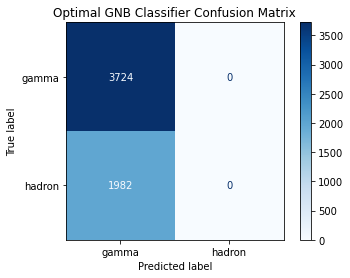

              precision    recall  f1-score   support

       gamma       0.65      1.00      0.79      3724
      hadron       0.00      0.00      0.00      1982

    accuracy                           0.65      5706
   macro avg       0.33      0.50      0.39      5706
weighted avg       0.43      0.65      0.52      5706

F1_Micro Score: 65.265%
F1_Macro Score: 39.491%



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Dummy optimization
dc_f1 = []
train_time_dc = 0
predict_time_dc = 0

scorer=['f1_micro','f1_macro']
for s in scorer:
  print('Dummy optimization - %s' % s)

  #Pipeline
  #αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  scaler = StandardScaler()
  ros = RandomOverSampler()
  clf = DummyClassifier() # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
  pipe = Pipeline(steps=[('scaler', scaler),('sampler', ros), ('gnb', clf)], memory = 'tmp')

  #Grid Search - KNN
  r=[0.55,0.8,1.0]

  strategy=['statified','most_frequent','prior''uniform','constant']
  estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy=r,gnb__strategy=strategy), scoring=s, cv=5, n_jobs=-1, verbose=10)

  import time
  start_time = time.time()
  estimator.fit(x_train, y_train)
  train_time = time.time()
  pred = estimator.predict(x_test)

  print('')
  print('Optimal parameters tuned on dev set:',estimator.best_params_)
  print('')

  train_time_dc = train_time - start_time
  predict_time_dc = time.time() - train_time
  print("Χρόνος fit=%s, Χρόνος predict=%s, Συνολικός χρόνος=%s  seconds" % (train_time_dc,predict_time_dc,train_time_dc+predict_time_dc))
  print('')

  disp = plot_confusion_matrix(estimator, x_test, y_test,
                                display_labels=label_names,
                                cmap=plt.cm.Blues,
                                normalize=None, values_format='d')
  disp.ax_.set_title('Optimal GNB Classifier Confusion Matrix')
  plt.show()

  print(classification_report(y_test, pred, target_names=label_names))
  Odc_f1_m = f1_score(y_test,pred,average='micro')
  Odc_f1_M = f1_score(y_test,pred,average='macro')
  dc_f1.append(Odc_f1_m)
  dc_f1.append(Odc_f1_M)
  print('F1_Micro Score: {:.3f}%'.format(100 * Odc_f1_m))
  print('F1_Macro Score: {:.3f}%'.format(100 * Odc_f1_M))
  print("")

GNB optimization - f1_micro
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Optimal parameters tuned on dev set: {'sampler__sampling_strategy': 0.55}

Χρόνος fit=2.925886392593384, Χρόνος predict=0.0019378662109375, Συνολικός χρόνος=2.9278242588043213  seconds



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


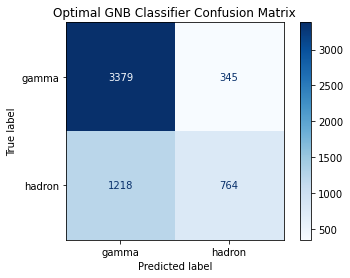

              precision    recall  f1-score   support

       gamma       0.74      0.91      0.81      3724
      hadron       0.69      0.39      0.49      1982

    accuracy                           0.73      5706
   macro avg       0.71      0.65      0.65      5706
weighted avg       0.72      0.73      0.70      5706

F1_Micro Score: 72.608%
F1_Macro Score: 65.325%

GNB optimization - f1_macro
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Optimal parameters tuned on dev set: {'sampler__sampling_strategy': 1.0}

Χρόνος fit=1.393446445465088, Χρόνος predict=0.00286102294921875, Συνολικός χρόνος=1.3963074684143066  seconds



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


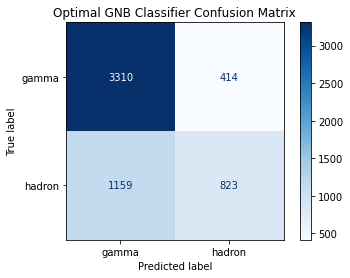

              precision    recall  f1-score   support

       gamma       0.74      0.89      0.81      3724
      hadron       0.67      0.42      0.51      1982

    accuracy                           0.72      5706
   macro avg       0.70      0.65      0.66      5706
weighted avg       0.71      0.72      0.70      5706

F1_Micro Score: 72.433%
F1_Macro Score: 65.967%



In [ ]:
#GNB optimization
gnb_f1 = []
train_time_gnb = 0
predict_time_gnb = 0

scorer=['f1_micro','f1_macro']
for s in scorer:
  print('GNB optimization - %s' % s)

  #Pipeline
  #αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  ros = RandomOverSampler()
  clf = GaussianNB() # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
  pipe = Pipeline(steps=[('sampler', ros), ('gnb', clf)], memory = 'tmp')

  #Grid Search - KNN
  r=[0.55,0.85,1.0]



  estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy=r), scoring=s, cv=5, n_jobs=-1, verbose=10)

  import time
  start_time = time.time()
  estimator.fit(x_train, y_train)
  train_time = time.time()
  pred = estimator.predict(x_test)

  print('')
  print('Optimal parameters tuned on dev set:',estimator.best_params_)
  print('')

  train_time_gnb = train_time - start_time
  predict_time_gnb = time.time() - train_time
  print("Χρόνος fit=%s, Χρόνος predict=%s, Συνολικός χρόνος=%s  seconds" % (train_time_gnb,predict_time_gnb,train_time_gnb+predict_time_gnb))
  print('')

  disp = plot_confusion_matrix(estimator, x_test, y_test,
                                display_labels=label_names,
                                cmap=plt.cm.Blues,
                                normalize=None, values_format='d')
  disp.ax_.set_title('Optimal GNB Classifier Confusion Matrix')
  plt.show()

  print(classification_report(y_test, pred, target_names=label_names))
  Oknn_f1_m = f1_score(y_test,pred,average='micro')
  Oknn_f1_M = f1_score(y_test,pred,average='macro')
  gnb_f1.append(Oknn_f1_m)
  gnb_f1.append(Oknn_f1_M)
  print('F1_Micro Score: {:.3f}%'.format(100 * Oknn_f1_m))
  print('F1_Macro Score: {:.3f}%'.format(100 * Oknn_f1_M))
  print("")

KNN optimization - f1_micro
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dis


Optimal parameters tuned on dev set: {'kNN__metric': 'euclidean', 'kNN__n_neighbors': 31, 'kNN__weights': 'distance', 'sampler__sampling_strategy': 0.8}

Χρόνος fit=90.18845844268799, Χρόνος predict=0.5165202617645264, Συνολικός χρόνος=90.70497870445251  seconds



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


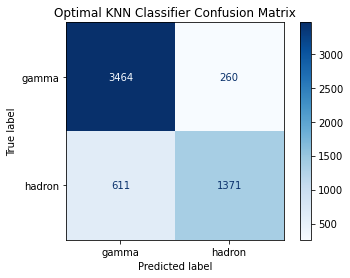

              precision    recall  f1-score   support

       gamma       0.85      0.93      0.89      3724
      hadron       0.84      0.69      0.76      1982

    accuracy                           0.85      5706
   macro avg       0.85      0.81      0.82      5706
weighted avg       0.85      0.85      0.84      5706

F1_Micro Score: 84.735%
F1_Macro Score: 82.362%

KNN optimization - f1_macro
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dis


Optimal parameters tuned on dev set: {'kNN__metric': 'euclidean', 'kNN__n_neighbors': 31, 'kNN__weights': 'distance', 'sampler__sampling_strategy': 0.8}

Χρόνος fit=89.52798223495483, Χρόνος predict=0.5149233341217041, Συνολικός χρόνος=90.04290556907654  seconds



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


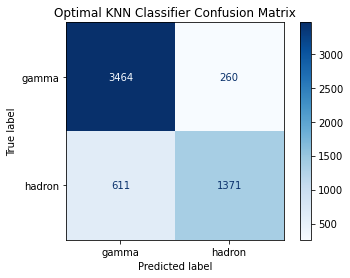

              precision    recall  f1-score   support

       gamma       0.85      0.93      0.89      3724
      hadron       0.84      0.69      0.76      1982

    accuracy                           0.85      5706
   macro avg       0.85      0.81      0.82      5706
weighted avg       0.85      0.85      0.84      5706

F1_Micro Score: 84.735%
F1_Macro Score: 82.362%



In [ ]:
#KNN optimization
knn_f1 = []
train_time_knn = 0
predict_time_knn = 0

scorer=['f1_micro','f1_macro']
for s in scorer:
  print('KNN optimization - %s' % s)

  #Pipeline
  # αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  scaler = StandardScaler()
  ros = RandomOverSampler()
  clf = KNeighborsClassifier(n_jobs=-1) # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
  pipe = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('kNN', clf)], memory = 'tmp')

  #Grid Search - KNN
  r=[0.55,0.8]

  # k = [1, 6, 11, 21, 31, 41] # η υπερπαράμετρος του ταξινομητή
  k = [1, 6, 11, 21, 31, 41] # η υπερπαράμετρος του ταξινομητή


  w=['uniform', 'distance']
  metrics=['euclidean','minkowski','mahalanobis']

  estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy=r,kNN__metric=metrics,kNN__weights=w,kNN__n_neighbors=k), scoring=s, cv=5, n_jobs=-1, verbose=10)

  import time
  start_time = time.time()
  estimator.fit(x_train, y_train)
  train_time = time.time()
  pred = estimator.predict(x_test)

  print('')
  print('Optimal parameters tuned on dev set:',estimator.best_params_)
  print('')

  train_time_knn = train_time - start_time
  predict_time_knn = time.time() - train_time
  print("Χρόνος fit=%s, Χρόνος predict=%s, Συνολικός χρόνος=%s  seconds" % (train_time_knn,predict_time_knn,train_time_knn+predict_time_knn))
  print('')

  disp = plot_confusion_matrix(estimator, x_test, y_test,
                                display_labels=label_names,
                                cmap=plt.cm.Blues,
                                normalize=None, values_format='d')
  disp.ax_.set_title('Optimal KNN Classifier Confusion Matrix')
  plt.show()

  print(classification_report(y_test, pred, target_names=label_names))
  Oknn_f1_m = f1_score(y_test,pred,average='micro')
  Oknn_f1_M = f1_score(y_test,pred,average='macro')
  knn_f1.append(Oknn_f1_m)
  knn_f1.append(Oknn_f1_M)
  print('F1_Micro Score: {:.3f}%'.format(100 * Oknn_f1_m))
  print('F1_Macro Score: {:.3f}%'.format(100 * Oknn_f1_M))
  print("")

In [ ]:
#MLP optimization
train_time_mlp = 0
predict_time_mlp = 0
mlp_f1 = []
scorer=['f1_micro','f1_macro']
for s in scorer:
  print('MLP optimization - %s' % s)
  #Pipeline
  # αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  scaler = StandardScaler()
  ros = RandomOverSampler()
  clf = MLPClassifier() # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
  pipe = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('mlp', clf)], memory = 'tmp')

  #Grid Search - KNN
  r=[0.55,0.8]

  hidden=[(50,),(100,),(150,)]
  activation=['relu','tanh']
  solver=['adam','sgd']
  iter=[50,100,150]
  learn_rate=['constant','invscaling']
  alpha=[0.00005,0.0001,0.0005]


  # estimator = GridSearchCV(pipe, dict(kNN__n_neighbors=k), cv=5, scoring='f1_macro', n_jobs=-1)
  estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy=r,mlp__hidden_layer_sizes=hidden,mlp__activation=activation,mlp__solver=solver,mlp__max_iter=iter,mlp__alpha=alpha,mlp__learning_rate=learn_rate),scoring=s, cv=5, n_jobs=-1, verbose=10)

  import time
  start_time = time.time()
  estimator.fit(x_train, y_train)
  train_time = time.time()
  pred = estimator.predict(x_test)

  print('')
  print('Optimal parameters tuned on dev set:',estimator.best_params_)
  print('')

  train_time_mlp = train_time - start_time
  predict_time_mlp = time.time() - train_time
  print("Χρόνος fit=%s, Χρόνος predict=%s, Συνολικός χρόνος=%s  seconds" % (train_time_mlp,predict_time_mlp,train_time_mlp+predict_time_mlp))
  print('')

  disp = plot_confusion_matrix(estimator, x_test, y_test,
                                display_labels=label_names,
                                cmap=plt.cm.Blues,
                                normalize=None, values_format='d')
  disp.ax_.set_title('Optimal MLP Classifier Confusion Matrix')
  plt.show()

  print(classification_report(y_test, pred, target_names=label_names))
  Omlp_f1_m = f1_score(y_test,pred,average='micro')
  Omlp_f1_M = f1_score(y_test,pred,average='macro')
  mlp_f1.append(Omlp_f1_m)
  mlp_f1.append(Omlp_f1_M)
  print('F1_Micro Score: {:.3f}%'.format(100 * Omlp_f1_m))
  print('F1_Macro Score: {:.3f}%'.format(100 * Omlp_f1_M))
  print("")

MLP optimization - f1_micro
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [ ]:
#SVM (non-linear kernel) optimization 
svm_f1 = []
train_time_svm = 0
predict_time_svm = 0
scorer=['f1_micro','f1_macro']
for s in scorer:
  print('SVM (non-linear kernel) optimization - %s' % s)



  #Pipeline
  # αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  scaler = StandardScaler()
  ros = RandomOverSampler()
  clf = SVC()
  pipe = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('svm', clf)], memory = 'tmp')

  #Grid Search - SVM
  r=[0.56,0.8]

  c = [0.1,1.0,10.0] # η υπερπαράμετρος του ταξινομητή
  gamma=['scale','auto']
  degree=[3,4,6]
  tol=[0.001,0.1]

  estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy=r,svm__C=c,svm__gamma=gamma,svm__degree=degree,svm__tol=tol), scoring=s, cv=5, n_jobs=-1, verbose=10)


  import time
  start_time = time.time()
  estimator.fit(x_train, y_train)
  train_time = time.time()
  pred = estimator.predict(x_test)

  print('')
  print('Optimal parameters tuned on dev set:',estimator.best_params_)
  print('')

  train_time_svm = train_time - start_time
  predict_time_svm = time.time() - train_time
  print("Χρόνος fit=%s, Χρόνος predict=%s, Συνολικός χρόνος=%s  seconds" % (train_time_svm,predict_time_svm,train_time_svm+predict_time_svm))
  print('')

  disp = plot_confusion_matrix(estimator, x_test, y_test,
                                display_labels=label_names,
                                cmap=plt.cm.Blues,
                                normalize=None, values_format='d')
  disp.ax_.set_title('Optimal non-linear SVM Classifier Confusion Matrix')
  plt.show()

  print(classification_report(y_test, pred, target_names=label_names))
  Osvm_f1_m = f1_score(y_test,pred,average='micro')
  Osvm_f1_M = f1_score(y_test,pred,average='macro')
  svm_f1.append(Osvm_f1_m)
  svm_f1.append(Osvm_f1_M)
  print('F1_Micro Score: {:.3f}%'.format(100 * Osvm_f1_m))
  print('F1_Macro Score: {:.3f}%'.format(100 * Osvm_f1_M))
  print("")

In [ ]:
#SVM (linear kernel) optimization 
lsvm_f1=[]
train_time_lsvm = 0
predict_time_lsvm = 0
scorer=['f1_micro','f1_macro']
for s in scorer:
  print('SVM (non-linear kernel) optimization - %s' % s)



  #Pipeline
  # αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  scaler = StandardScaler()
  ros = RandomOverSampler()
  clf = LinearSVC()
  pipe = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('svm', clf)], memory = 'tmp')

  #Grid Search - SVM
  r=[0.55,0.75,0.95]

  c = [0.1,1.0,10.0] # η υπερπαράμετρος του ταξινομητή
  loss=['hinge','squared_hinge']
  tol=[0.001,0.1]


  w=['uniform', 'distance']
  metrics=['euclidean','minkowski','mahalanobis']

  estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy=r,svm__C=c,svm__loss=loss,svm__tol=tol), scoring=s, cv=5, n_jobs=-1, verbose=10)


  import time
  start_time = time.time()
  estimator.fit(x_train, y_train)
  train_time = time.time()
  pred = estimator.predict(x_test)

  print('')
  print('Optimal parameters tuned on dev set:',estimator.best_params_)
  print('')

  train_time_lsvm = train_time - start_time
  predict_time_lsvm = time.time() - train_time
  print("Χρόνος fit=%s, Χρόνος predict=%s, Συνολικός χρόνος=%s  seconds" % (train_time_svm,predict_time_svm,train_time_svm+predict_time_svm))
  print('')

  disp = plot_confusion_matrix(estimator, x_test, y_test,
                                display_labels=label_names,
                                cmap=plt.cm.Blues,
                                normalize=None, values_format='d')
  disp.ax_.set_title('Optimal non-linear SVM Classifier Confusion Matrix')
  plt.show()

  print(classification_report(y_test, pred, target_names=label_names))
  OLsvm_f1_m = f1_score(y_test,pred,average='micro')
  OLsvm_f1_M = f1_score(y_test,pred,average='macro')
  lsvm_f1.append(OLsvm_f1_m)
  lsvm_f1.append(OLsvm_f1_M)
  print('F1_Micro Score: {:.3f}%'.format(100 * OLsvm_f1_m))
  print('F1_Macro Score: {:.3f}%'.format(100 * OLsvm_f1_M))
  print("")

In [ ]:
#Time chart
from google.colab import data_table


heading = ['Classifier','Train time','Test time']
dc = ['Dummy',train_time_dc,predict_time_dc]
gnb = ['GNB',train_time_gnb,predict_time_gnb]
knn = ['KNN',train_time_knn,predict_time_knn]
mlp = ['MLP',train_time_mlp,predict_time_mlp]
svm = ['SVM',train_time_svm,predict_time_svm]
lsvm = ['LSVM',train_time_lsvm,predict_time_lsvm]

table = [heading,dc,gnb,knn,mlp,svm,lsvm]
table = np.array(table)

df = pd.DataFrame(table)

data_table.DataTable(df,include_index=False)

In [ ]:
#F1_micro comparison chart

labels = ['Dummy','Naive Gauss','KNN','SVM','MLP']
values = np.array([dc_f1_m,gauss_f1_m,knn_f1_m,svm_f1_m,mlp_f1_m])

print(dc_f1[0])

values_opt = np.array([dc_f1[0],gnb_f1[0],knn_f1[0],svm_f1[0],mlp_f1[0]])
  

f1_macros=[]


x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, values, width, label='f1_micros')
rects2 = ax.bar(x + width/2, values_opt, width, label='f1_micros after optimization')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Micro score before vs after optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

inc = [labels[i]+'=='+str("{:.2f}".format(((values_opt[i]-values[i])/values[i])*100))+'%' for i in range(len(values))]
print(inc)

In [ ]:
#F1_macro comparison chart

labels = ['Dummy','Naive Gauss','KNN','SVM','MLP']
values = np.array([dc_f1_M,gauss_f1_M,knn_f1_M,svm_f1_M,mlp_f1_M])
values_opt = np.array([dc_f1[3],gnb_f1[3],knn_f1[3],svm_f1[3],mlp_f1[3]])



x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, values, width, label='f1_macros')
rects2 = ax.bar(x + width/2, values_opt, width, label='f1_macros after optimization')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Macro score before vs after optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

inc = [labels[i]+'=='+str("{:.2f}".format(((values_opt[i]-values[i])/values[i])*100))+'%' for i in range(len(values))]
print(inc)

KAGGLE


Go to this url:https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly


In [ ]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls
download('https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction/download','archive')
!apt-get install unzip

gdrive	sample_data
Download file... archive ...
File downloaded
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!unzip archive.zip -d kgg


unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [2]:
import pandas as pd
data = pd.read_csv("/content/gdrive/My Drive/kaggle/kgg/data.csv")
data.head()
print (data.shape)
print("To dataset έχει ",data.shape[0],"δείγματα και ",data.shape[1]-1,"χαρακτηριστικά")

(6819, 96)
To dataset έχει  6819 δείγματα και  95 χαρακτηριστικά


In [3]:
# Τα χαρακτηριστικά αποτελούνται από όλες τις κολόνες των δεδομένων εκτός της 1ης 
# η οποία αποτελεί τις ετικέτες κάθε δείγματος. 
features_data = data.iloc[:, 1:857]
# Μετατρέπουμε τα dataframes σε numpy array
features = features_data.values
# Ελέγχουμε αν τα χαρακτηριστικά έχουν τη μορφή που θέλουμε
print ("features shape:\n",features.shape,"\n")
print("features:\n",features)
# Ελέγχουμε το ποσοστό μηδενικών features
cnt = 0
for x in features:
  for y in x:
    if (y==0):
      cnt+=1
print("\nTo ποσοστό μηδενικών features(%) είναι:\n")
print(100*cnt/(6819*95))

features shape:
 (6819, 95) 

features:
 [[0.37059426 0.42438945 0.40574977 ... 0.56405011 1.         0.01646874]
 [0.46429094 0.53821413 0.51673002 ... 0.57017495 1.         0.02079431]
 [0.42607127 0.49901875 0.47229509 ... 0.56370608 1.         0.01647411]
 ...
 [0.47272461 0.533744   0.52063815 ... 0.5651584  1.         0.09764874]
 [0.50626432 0.5599106  0.55404465 ... 0.56530151 1.         0.04400945]
 [0.49305319 0.57010467 0.54954762 ... 0.56516694 1.         0.23390224]]

To ποσοστό μηδενικών features(%) είναι:

2.256234515016093


In [5]:

import numpy as np

target_data = data.iloc[:, [0]]

# convert dataframe to an 1-D numpy array
target = target_data.values

# create and print a 2-D array with first collumn the label and second collumn the frequencies 
label, frequencies = np.unique(target, return_counts=True)
print ("frequencies:\n",np.asarray((label, frequencies)).T,"\n")
# number of total samples
total_samples = target.shape[0]
print("total samples=",total_samples,"\n")

# create and print a 2-D array with first collumn the name of the label and second collumn the the presentage rate this label appears
percentage = (frequencies / total_samples) * 100
print ("percentages\n",np.asarray((label, percentage)).T)

frequencies:
 [[   0 6599]
 [   1  220]] 

total samples= 6819 

percentages
 [[ 0.         96.77372049]
 [ 1.          3.22627951]]


Διαχωρίζουμε σε train και test set. Εάν υπάρχουν απουσιάζουσες τιμές και μη διατεταγμένα χαρακτηριστικά διαχειριστείτε τα και αιτιολογήστε τις επιλογές σας.

In [6]:
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(features, target, test_size=0.3)

BASELINE CLARIFICATION

In [7]:
import seaborn as sns

def plot_classification_report(y_tru, y_prd, figsize=(5, 5), ax=None):

    plt.figure(figsize=figsize)
    plt.title("Classification Report")
    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

#DUMMY CLASSIFIERS

Για ενα Dummy classifier κάνουμε fit και στη συνέχεια 
υπολογίζουμε τα F1 micro,F1 macro scores,καθώς και τους
Confusion Matrixes.                


 Strategy: uniform

F1 micro 
0.5024437927663734 

F1 macro 
0.3574160252636879 



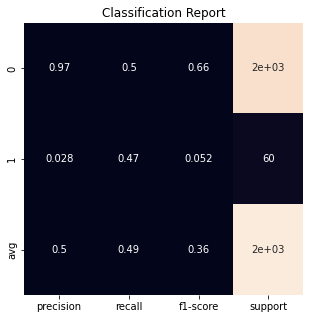

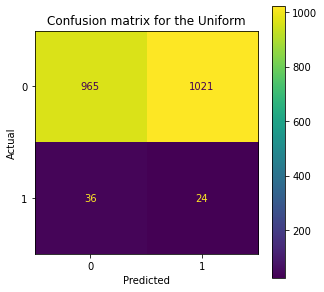

################################################################################
################################################################################
################################################################################
Strategy: constant=1
F1 micro 
0.02932551319648094 

F1 macro 
0.028490028490028494 



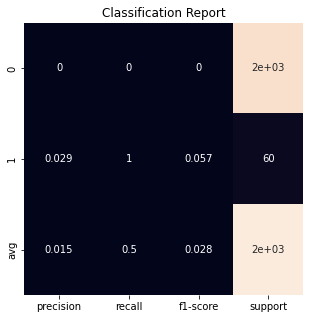

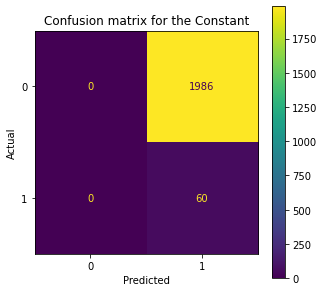

################################################################################
################################################################################
################################################################################
Strategy: Most Frequent

F1 micro 
0.9706744868035191 

F1 macro 
0.49255952380952384 



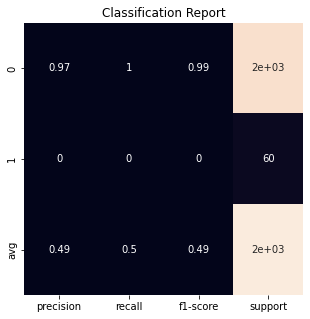

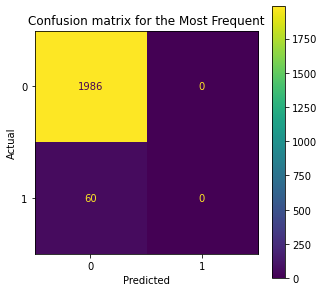

################################################################################
################################################################################
################################################################################
Strategy: stratified

F1 micro 
0.9403714565004888 

F1 macro 
0.5293642952493721 



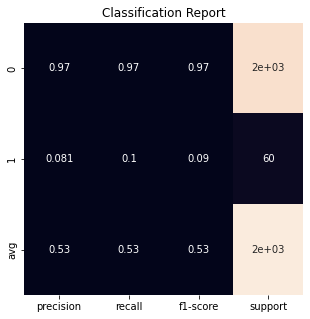

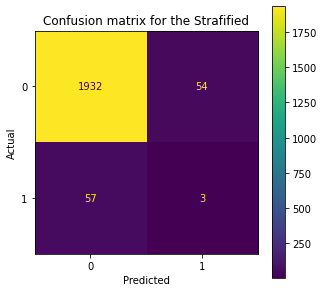

################################################################################
################################################################################
################################################################################


In [17]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.dummy   import DummyClassifier
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

f1_micro = {}
f1_macro = {}

# Dummy Strategy: Uniform 
dc_uniform = DummyClassifier(strategy="uniform")
dc_uniform.fit(train,train_labels)

preds = dc_uniform.predict(test)

print('\033[94m'+" Strategy: uniform"+'\033[0m'+"\n")
plot_classification_report(test_labels,preds)

f1_micro['Unif']=f1_score(test_labels,preds,average='micro')
f1_macro['Unif']=f1_score(test_labels,preds,average='macro')

print("F1 micro ")
print(f1_micro['Unif'],"\n")
print("F1 macro ")
print(f1_macro['Unif'],"\n")

fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(dc_uniform, test, test_labels,ax=ax)  
plt.title('Confusion matrix for the Uniform')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  


print("#"*80)
print("#"*80)
print("#"*80)

# Strategy: Constant=1
dc_constant1 = DummyClassifier(strategy="constant",constant=1)
dc_constant1.fit(train,train_labels)

pred_C1 = dc_constant1.predict(test)

print('\033[94m'+"Strategy: constant=1"+'\033[0m')
plot_classification_report(test_labels,pred_C1)

f1_micro['C1']=f1_score(test_labels,pred_C1,average='micro')
f1_macro['C1']=f1_score(test_labels,pred_C1,average='macro')

print("F1 micro ")
print(f1_micro['C1'],"\n")
print("F1 macro ")
print(f1_macro['C1'],"\n")

fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(dc_constant1, test, test_labels,ax=ax)  
plt.title('Confusion matrix for the Constant')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  

print("#"*80)
print("#"*80)
print("#"*80)

# Strategy: Most Frequent
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_most_frequent.fit(train,train_labels)

pred_MF = dc_most_frequent.predict(test)

print('\033[94m'+"Strategy: Most Frequent"+'\033[0m'+"\n")
plot_classification_report(test_labels,pred_MF)

f1_micro['MFreq']=f1_score(test_labels,pred_MF,average='micro')
f1_macro['MFreq']=f1_score(test_labels,pred_MF,average='macro')

print("F1 micro ")
print(f1_micro['MFreq'],"\n")
print("F1 macro ")
print(f1_macro['MFreq'],"\n")

fig, ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(dc_most_frequent, test, test_labels, ax=ax)
plt.title('Confusion matrix for the Most Frequent')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  


print("#"*80)
print("#"*80)
print("#"*80)

# Strategy: Strafified
dc_stratified = DummyClassifier(strategy="stratified")
dc_stratified.fit(train,train_labels)

pred_Strat = dc_stratified.predict(test)

print('\033[94m'+"Strategy: stratified"+'\033[0m'+"\n")
plot_classification_report(test_labels,pred_Strat)


f1_micro['Strat']=f1_score(test_labels,pred_Strat,average='micro')
f1_macro['Strat']=f1_score(test_labels,pred_Strat,average='macro')

print("F1 micro ")
print(f1_micro['Strat'],"\n")
print("F1 macro ")
print(f1_macro['Strat'],"\n")

fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(dc_stratified, test, test_labels,ax=ax)
plt.title('Confusion matrix for the Strafified')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  
print("#"*80)
print("#"*80)
print("#"*80)

#KNN

################################################################################
################################################################################
################################################################################
k Nearest Neighbors Model


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1986
           1       0.00      0.00      0.00        60

    accuracy                           0.97      2046
   macro avg       0.49      0.50      0.49      2046
weighted avg       0.94      0.97      0.96      2046

F1 micro
0.9682306940371457 

F1 macro
0.4919294760367519 



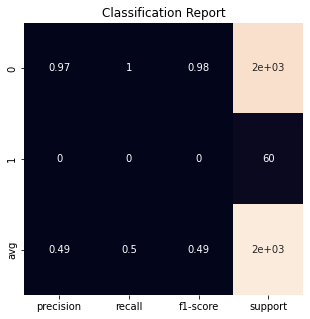

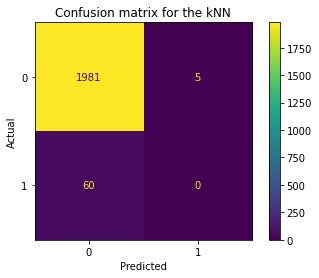

################################################################################
################################################################################
################################################################################


In [15]:
print("#"*80)
print("#"*80)
print("#"*80)
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier() 
clf.fit(train, train_labels)

knn_pred = clf.predict(test)


print('\033[94m'+"k Nearest Neighbors Model"+'\033[0m'+"\n\n")
print(classification_report(test_labels,knn_pred))


plot_classification_report(test_labels,knn_pred)

f1_micro['kΝΝ']=f1_score(test_labels,knn_pred,average='micro')
f1_macro['kΝΝ']=f1_score(test_labels,knn_pred,average='macro')


print("F1 micro")
print(f1_micro['kΝΝ'],"\n")
print("F1 macro")
print(f1_macro['kΝΝ'],"\n")

plot_confusion_matrix(clf, test, test_labels)  
plt.title('Confusion matrix for the kNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  
print("#"*80)
print("#"*80)
print("#"*80)

# GAUSSIAN NAIVE BAYES

################################################################################
################################################################################
################################################################################
Gaussian Naive Bayes


              precision    recall  f1-score   support

           0       0.98      0.03      0.06      1986
           1       0.03      0.98      0.06        60

    accuracy                           0.06      2046
   macro avg       0.51      0.51      0.06      2046
weighted avg       0.96      0.06      0.06      2046
 


F1 micro
0.06060606060606061 

F1 macro
0.060597981882811604 



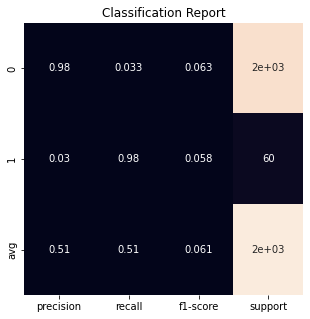

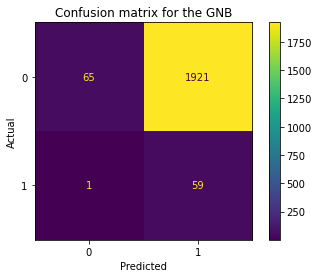

################################################################################
################################################################################
################################################################################


In [14]:
print("#"*80)
print("#"*80)
print("#"*80)

from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
gnb.fit(train,train_labels)

gnb_pred = gnb.predict(test)

print('\033[94m'+"Gaussian Naive Bayes"+'\033[0m'+"\n\n")
print(classification_report(test_labels,gnb_pred),"\n\n")

plot_classification_report(test_labels,gnb_pred)

f1_micro['GNB']=f1_score(test_labels,gnb_pred,average='micro')
f1_macro['GNB']=f1_score(test_labels,gnb_pred,average='macro')

print("F1 micro")
print(f1_micro['GNB'],"\n")
print("F1 macro")
print(f1_macro['GNB'],"\n")

plot_confusion_matrix(gnb, test, test_labels)  
plt.title('Confusion matrix for the GNB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("#"*80)
print("#"*80)
print("#"*80)

#MLP

Για αυτο το μοντελο χρησιμοποιηθηκαν τα default settings του MLPClassifier ,δεν εγινε περεταιρο παραμετροποιηση

Multilayer Perceptron


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1986
           1       0.06      0.07      0.06        60

    accuracy                           0.94      2046
   macro avg       0.51      0.52      0.52      2046
weighted avg       0.94      0.94      0.94      2046
 


F1 micro
0.9398826979472141 

F1 macro 
0.5150079689183278 



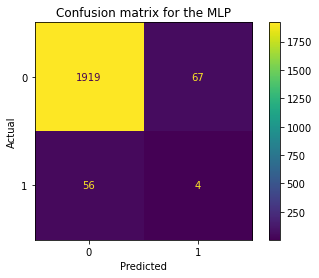

In [12]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

clf.fit(train,train_labels)
mlp_pred = clf.predict(test)

print('\033[94m'+"Multilayer Perceptron"+'\033[0m'+"\n\n")
print(classification_report(test_labels,mlp_pred),"\n\n")

f1_micro['MLP']=f1_score(test_labels,mlp_pred,average='micro')
f1_macro['MLP']=f1_score(test_labels,mlp_pred,average='macro')

print("F1 micro")
print(f1_micro['MLP'],"\n")
print("F1 macro ")
print(f1_macro['MLP'],"\n")

plot_confusion_matrix(clf, test, test_labels)  
plt.title('Confusion matrix for the MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

#SVM

SVM


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1986
           1       0.00      0.00      0.00        60

    accuracy                           0.97      2046
   macro avg       0.49      0.50      0.49      2046
weighted avg       0.94      0.97      0.96      2046
 


F1 micro
0.9706744868035191 

F1 macro 
0.49255952380952384 



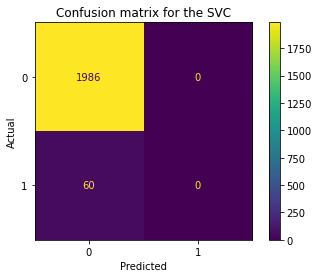

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

f1_micro = {}
f1_macro = {}

svc = SVC()

svc.fit(train,train_labels)
svc_pred = svc.predict(test)

print('\033[94m'+"SVM"+'\033[0m'+"\n\n")
print(classification_report(test_labels,svc_pred),"\n\n")

f1_micro['SVC']=f1_score(test_labels,svc_pred,average='micro')
f1_macro['SVC']=f1_score(test_labels,svc_pred,average='macro')

print("F1 micro")
print(f1_micro['SVC'],"\n")
print("F1 macro ")
print(f1_macro['SVC'],"\n")

plot_confusion_matrix(svc, test, test_labels)  
plt.title('Confusion matrix for the SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, svc_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1986    0]
 [  60    0]]

True Positives(TP) =  1986

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  60


In [20]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, svc_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1986
           1       0.00      0.00      0.00        60

    accuracy                           0.97      2046
   macro avg       0.49      0.50      0.49      2046
weighted avg       0.94      0.97      0.96      2046



In [21]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

recall = TP / float(TP + FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

true_positive_rate = TP / float(TP + FN)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

false_positive_rate = FP / float(FP + TN)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

specificity = TN / (TN + FP)
print('Specificity : {0:0.4f}'.format(specificity))

Classification accuracy : 0.9707
Classification error : 0.0293
Precision : 1.0000
Recall or Sensitivity : 0.9707
True Positive Rate : 0.9707
False Positive Rate : nan
Specificity : nan


Aπεικονίζει τη διαγνωστική ικανότητα ενός δυαδικού συστήματος ταξινομητή καθώς το όριο διάκρισής του ποικίλλει.

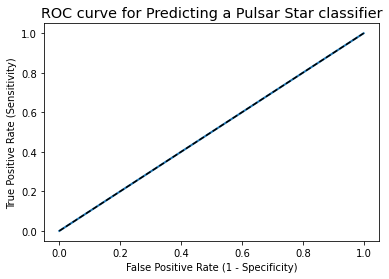

In [ ]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, svc_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Pulsar Star classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

#ΑΠΟΤΕΛΕΣΜΑΤΑ

Οι Dummy classifiers με constant τιμές,οπως και ηταν αναμενομενο καθως κανουμε multiclass classification, έχουν πάρα πολύ χαμηλή αποτελεσματικότητα.Στην καλύτερη περίπτωση φτάνουν σε αποτελεσματικότητα ίση με αυτή της συχνότερα εμφανιζόμενης κλάσης.
Ο ταξινομητής με την υψηλότερα ακρίβεια είναι ο ΚΝΝ ταξινομητής,ύστερα ο SVC και ο MLP.Τέλος ακολουθεί ο GNB.


Οι constant classifiers είχαν καλύτερη απόδοση στο f1-micro score,συγκριτικά με το f1-macro.Αυτό συμβαίνει διότι το macro score συνυπολογίζei κάθε κλάση ισάξια,ενώ στο micro score κάθε κλάση συνεισφέρει στο αποτέλεσμα σύμφωνα με το ποσοστό εμφάνισής της κάθε κλάσης.

Οι MLP,SVC και GNB ταξινομητές πετυχαίνουν πάνω από 90% ακρίβεια,οπως και ο kNN.Ο GNB δεν συμπεριφέρεται αρκετά καλά,κατι το οποιο δεν περιμεναμε, διότι δεν επηρεάζεται από το μεγάλο πλήθος των κλάσεων συγκριτικά με τα δεδομένα μας και οι κλάσεις είναι ανεξάρτητες μεταξύ τους.

Για να επιτευχθουν καλυτερα αποτελεσματα πρεπει να προχωρησουμε σε επεξεργασια των δεδομενων πριν αυτα δωθουν στους ταξινομητες και σε παραμετροποιηση αυτων.

#Βελτιστοπιηση

In [23]:
from sklearn.feature_selection import VarianceThreshold

train_variance = train.var(axis=1)
print("Train variance: (sorted)\n",sorted(train_variance),"\n")
print("Max variance of a label:\n",np.max(train_variance),"\n")
print("Mean:\n",train_variance.mean(),"\n")

Train variance: (sorted)
 [0.09237665136341855, 0.09422199641956977, 0.09480495312157788, 0.09688680889412252, 0.09704781000584431, 0.09797200134115434, 0.09870850671608697, 0.10051397716612703, 0.10252127856782266, 0.10288718103268178, 0.10316669484044914, 0.10435873978127262, 0.10500191322647358, 0.10550272822551403, 0.10595190102818161, 0.10617238584356163, 0.10692453681035943, 0.10698180320219998, 0.10704527324604304, 0.10710888615764079, 0.10719480735054208, 0.10733928465616484, 0.10759205128886701, 0.10909174671290656, 0.10932315895254109, 0.10953112547414443, 0.10967838256003655, 0.1099326471634172, 0.11012214625586646, 0.11026165923432056, 0.11085974447805115, 0.11148743055837686, 0.11159066900066997, 0.1135006216494048, 0.1141512659340563, 0.1144899069933561, 0.11572062148482351, 3799682963758.0127, 3799682974458.0215, 3799682976433.0903, 3799682976747.7534, 3799682978810.0933, 16915729365676.525, 28817222915881.86, 36256398468795.27, 47034787373638.555, 337462602542039.44, 72

trainPCA shape
(4773, 70)
################################################################################
################################################################################
################################################################################
cum_evar
[0.22432236 0.37874121 0.50500792 0.62641375 0.73767685 0.82808164
 0.91104728 0.97799389 0.98299356 0.98744891 0.99124229 0.99362802
 0.99517607 0.99635286 0.9974247  0.99817642 0.9987687  0.99933056
 0.99958802 0.99978502 0.99994598 0.99997782 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
###

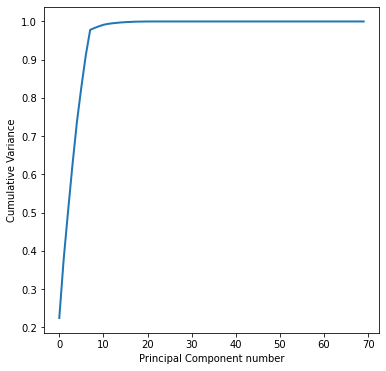

In [32]:
from sklearn.decomposition import PCA

n = 70
pca = PCA(n_components=n)

trainPCA = pca.fit_transform(train)
testPCA = pca.transform(test)
print('\033[94m'+"trainPCA shape"+'\033[0m')
print(trainPCA.shape)
print("#"*80)
print("#"*80)
print("#"*80)
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print('\033[94m'+"cum_evar"+'\033[0m')
print(cum_evar)
print("#"*80)
print("#"*80)
print("#"*80)
plt.figure(1, figsize=(6, 6))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

Ετσι πετυχαινουμε την κανονικοποιηση των χαρακτηριστικων του data set μας.
Ορίζουμε ένα κατώφλι,όπου γίνονται αποδεκτά χαρακτηριστικά όπου έχουν μεγαλύτερη διακύμανση από αυτό.Για χαρακτηριστικά τα οποια θα προκαλεσουν ενδεχομενα προβληματα στην μαθηση, λογω των πολυ μεγαλων διαφορων στις τιμες κανονικοποιουνται.Η κανονικοποίηση μετασχηματίζει τις τιμές των χαρακτηριστικών ώστε να αμβλυνθούν αυτές οι διαφορές αυτες .Διαιρουμε με τη διαφορά μεγίστου-ελαχίστου (feature scaling) οπότε οι τιμές όλων των χαρακτηριστικών κλιμακώνονται γραμμικά στο διάστημα [0,1] ή με το standard score του κάθε χαρακτηριστικού, που κάνει το χαρακτηριστικό να έχει μέση τιμή μηδέν και διακύμανση μονάδα. H μετατροπή σε standard score είναι απαραίτητη σε πολλούς ταξινομητές για να συμπεριφερθούν σωστά. Επίσης είναι πιο ανθεκτική από την min-max σε σποραδικές τιμές που είναι πολύ μακριά απο τη μέση τιμή και τις υπόλοιπες τιμές του χαρακτηριστικού. 
Τελος μειωνουμε τις διαστασεις των δεδομενων μας χρησιμοποιωντας την μεθοδο Principal Components Analysis (PCA).Από το γράφημα παρατηρούμε πως με 30 συνιστώσες περιγράφουμε το μεγαλύτερο κομμάτι της διακύμανσης του data set μας.


##ΠΑΡΑΜΕΤΡΟΠΟΙΗΣΗ ΤΑΞΙΝΟΜΗΤΩΝ

Θα γινει χρηση της μεθοδου grid search

In [61]:
##grid_search implementation

def grid_search(train, test, train_labels, test_labels, steps, grid_params, score):
  pipe = Pipeline(steps , memory = 'tmp')
  estimator = GridSearchCV(pipe, grid_params, cv=5,scoring=score ,n_jobs=-1,verbose=1)
  start_time = time.time()
  estimator.fit(train, train_labels)
  preds = estimator.predict(test)
  ttime =  time.time() - start_time
  return preds, ttime, estimator.best_estimator_

#KNN Utilization

In [43]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

selector =VarianceThreshold()

vthreshold = [0, 0.001, 0.002, 0.005, 0.01]

k = [1, 3, 5, 7, 11, 15, 19]

weights_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming'] 
pipe = Pipeline(steps=[('selector', selector), ('kNN', clf)], memory = 'tmp')

In [48]:
vthreshold = [ 0.1, 0.2, 1, 5, 20, 500, 10000 ] 
n_components = [7, 15, 20, 25]
k = [1, 3, 5, 7, 9, 11] 

estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, kNN__n_neighbors=k, kNN__weights=weights_options, kNN__metric=metric_options), cv=5, scoring='f1_micro', n_jobs=-1, verbose=1)

In [50]:
import time

start_time = time.time()
estimator.fit(train, train_labels)
print("total time: fit and predict: %s seconds" % (time.time() - start_time))
preds = estimator.predict(test)
print (classification_report(test_labels, preds))
print("#"*80)
print("#"*80)

print (estimator.best_estimator_)
print (estimator.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
total time: fit and predict: 184.82351541519165 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1986
           1       0.00      0.00      0.00        60

    accuracy                           0.97      2046
   macro avg       0.49      0.50      0.49      2046
weighted avg       0.94      0.97      0.96      2046



Πετυχαμε το ιδιο score με πριν ,το οποιο βεβαια ηταν ηδη πολυ υψηλο.Συνεχιζουμε με την τεχνικη του PCA

In [57]:
selector =VarianceThreshold()
pca = PCA()

vthreshold = [0]
n_components = [50,100,120,140,160,180,200,220,240,260,279]
k = [ 7,9, 10,11,12,13, 14,15,16, 20]

weights_options = ['distance']
metric_options = ['euclidean','manhattan'] 
pipe = Pipeline(steps=[('selector', selector),('pca',pca),('kNN', clf)], memory = 'tmp')

estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, kNN__n_neighbors=k,kNN__weights=weights_options, kNN__metric=metric_options, pca__n_components=n_components), cv=5, scoring='f1_micro', n_jobs=-1)

start_time = time.time()
estimator.fit(train, train_labels)
total_time = (time.time() - start_time)

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))

print (classification_report(test_labels, preds))

print (estimator.best_estimator_)
print (estimator.best_params_)

Συνολικός χρόνος fit και predict: 27.617145776748657 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1986
           1       0.00      0.00      0.00        60

    accuracy                           0.97      2046
   macro avg       0.49      0.50      0.49      2046
weighted avg       0.94      0.97      0.96      2046

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0)),
                ('pca', PCA(n_components=50)),
                ('kNN',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=10,
                                      weights='distance'))])
{'kNN__metric': 'euclidean', 'kNN__n_neighbors': 10, 'kNN__weights': 'distance', 'pca__n_components': 50, 'selector__threshold': 0}


Και με την τεχνικη του PCA πετυχαινουμε την ιδια αποδοση παρα το progressive search.Αρα εκτιμουμε οτι δεν γινεται περαιτερω βελτιωση της αποδοσης.

#MLP Utilization

Κανουμε παραμετροποιηση του νευρωνικου δικτυου

In [58]:
hidden_layer_sizes = [4, 8, 12, 16, 20]
activations = ['logistic', 'tanh', 'relu']
solvers = ['lbfgs', 'sgd', 'adam']
max_iters = [50, 100, 200, 300]
learning_rates = ['constant', 'invscaling', 'adaptive']
alphas = [0.01, 0.001, 0.0001]

In [68]:
model=[('mlp', MLPClassifier())]
grid_params = {}
grid_params['mlp__hidden_layer_sizes'] = hidden_layer_sizes
grid_params['mlp__activation'] = activations
grid_params['mlp__solver'] = solvers
grid_params['mlp__max_iter'] = max_iters
grid_params['mlp__learning_rate'] = learning_rates
grid_params['mlp__alpha'] = alphas

preds_micro, ttime_micro, best_micro = grid_search(train, test, train_labels, test_labels, model, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_search(train, test, train_labels, test_labels, model, grid_params, 'f1_macro')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [70]:
mlp_f1_micro_opt = f1_score(test_labels, preds_micro, average="micro")
mlp_f1_macro_opt = f1_score(test_labels, preds_macro, average="macro")

print('F1 micro: %f' %mlp_f1_micro_opt)
print('time for fit and predict: %f' %ttime_micro)
print('best f1-micro:')
print(best_micro)

print("#"*80)
print("#"*80)


print('F1 macro: %f' %mlp_f1_macro_opt)
print('time for fit and predict: %f' %ttime_macro)
print('best f1-macro:')
print(best_macro)

F1 micro: 0.970674
time for fit and predict: 51.278120
best f1-micro:
Pipeline(memory='tmp',
         steps=[('mlp',
                 MLPClassifier(activation='logistic', alpha=0.001,
                               hidden_layer_sizes=20, learning_rate='adaptive',
                               max_iter=20, solver='lbfgs'))])
################################################################################
################################################################################
F1 macro: 0.513934
time for fit and predict: 52.554693
best f1-macro:
Pipeline(memory='tmp',
         steps=[('mlp',
                 MLPClassifier(alpha=0.001, hidden_layer_sizes=30,
                               learning_rate='adaptive', max_iter=30))])


Θετουμε 'learning rate = adaptive' και 'alpha = 0.001'.Για ακομα καλυτερα αποτελεσματα

In [71]:
hidden_layer_sizes = [ 20, 30 ]
activations = ['logistic', 'tanh', 'relu']
solvers = ['lbfgs', 'sgd', 'adam']
max_iters = [20,30]
learning_rates = [ 'adaptive']
alphas = [0.001]
vthreshold = [0.0, 0.01, 0.1] 


pipe = [('selector', selector), ('mlp', MLPClassifier())]
grid_params = {'mlp__hidden_layer_sizes':hidden_layer_sizes,
               'mlp__activation':activations,
               'mlp__solver':solvers,
               'mlp__max_iter':max_iters,
               'mlp__learning_rate':learning_rates,
               'mlp__alpha':alphas,
               'selector__threshold':vthreshold
               }

preds_micro, ttime_micro, best_micro = grid_search(train, test, train_labels, test_labels, pipe, grid_params, 'f1_micro')
preds_macro, ttime_macro, best_macro = grid_search(train, test, train_labels, test_labels, pipe, grid_params, 'f1_macro')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [72]:
mlp_f1_micro_opt_sel = f1_score(test_labels, preds_micro, average="micro")
mlp_f1_macro_opt_sel = f1_score(test_labels, preds_macro, average="macro")


print('F1 micro: %f' %mlp_f1_micro_opt)
print('time for fit and predict: %f' %ttime_micro)
print('best f1-micro:')
print(best_micro)


print('F1 macro: %f' %mlp_f1_macro_opt)
print('time for fit and predict: %f' %ttime_macro)
print('best f1-macro:')
print(best_macro)

F1 micro: 0.970674
time for fit and predict: 149.136294
best f1-micro:
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.01)),
                ('mlp',
                 MLPClassifier(activation='logistic', alpha=0.001,
                               hidden_layer_sizes=30, learning_rate='adaptive',
                               max_iter=20, solver='lbfgs'))])
F1 macro: 0.513934
time for fit and predict: 150.007047
best f1-macro:
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('mlp',
                 MLPClassifier(alpha=0.001, hidden_layer_sizes=20,
                               learning_rate='adaptive', max_iter=30))])


ΑΠΟΤΕΛΕΜΣΑΤΑ

Από τις τιμές των f1 που προέκυψαν καταλήγουμε στο οτι η χρήση selector βελτιώνει τα αποτελέματα οπως και η χρήση PCA, μιας και με 30 συνιστώσες κρατάμε πιθανότατα όλο το ποσοστό πληροφορίας που απαιτείται για να έχουμε βέλτιστα αποτελέσματα.Εχουμε σημαντικη βελτιωση και με scaler, ενώ και η χρήση του oversampling δίνει καλύτερο αποτέλεσμα της μετρικής f1 macro.

#SVC

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score

svc = LinearSVC()
scaler = MinMaxScaler()
selector = VarianceThreshold()
pca = PCA()


LinearSVC_param = {
              'linearsvc__C': [1, 2, 3],
              'linearsvc__tol': [ 0.0005, 0.00075, 0.001, 0.0015],
              'linearsvc__loss':['hinge', 'squared_hinge'],
              'pca__n_components': [80,85,90,95],
              'linearsvc__multi_class':['ovr', 'crammer_singer']
              }

pipe = make_pipeline(scaler,pca,svc)

linearsvc_macro = GridSearchCV(pipe, LinearSVC_param, cv=5, scoring='f1_macro',n_jobs=-1, verbose=1)
linearsvc_micro = GridSearchCV(pipe, LinearSVC_param, cv=5, scoring='f1_micro', n_jobs=-1, verbose=1)
linearsvc_macro.fit(train, train_labels)
linearsvc_micro.fit(train, train_labels)


preds_micro = linearsvc_micro.predict(test) 
preds_macro = linearsvc_macro.predict(test)
LinearSVC_f1_micro_opt = f1_score(test_labels, preds_micro, average="micro")
LinearSVC_f1_macro_opt = f1_score(test_labels, preds_macro, average="macro")


print('F1 micro: %f' %LinearSVC_f1_micro_opt)
print('best f1-micro:')
print(linearsvc_micro.best_estimator_)
print("Best parameters = ",linearsvc_micro.best_params_)
plot_classification_report(test_labels,preds_micro)

print('F1 macro: %f' %LinearSVC_f1_macro_opt)
print('best f1-macro:')
print(linearsvc_macro.best_estimator_)
print("Best parameters = ",linearsvc_macro.best_params_)
plot_classification_report(test_labels,preds_macro)

Τα αποτελέσματά μας βελτιώθηκαν σημαντικά σε όλα τα μοντέλα χρησιμοποιώντας την μέθοδο GridSearchCV. Αυτό μας δείχνει τη σημαντικότητα βελτιστοποίησης των hyperparameters των μοντέλων μας και την ανάγκη εύρεσης του βέλτιστου pipelining για την εκτέλεση μιας διεργασίας machine learning.